In [1]:
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

In [2]:
df = pd.read_csv("../train.csv", index_col=0)
df_independent = df.iloc[:, :-1]

In [13]:
def calculate_vif(features: list, data: pd.DataFrame):
    """calculate VIF value for the features given on the data"""
    vif = {}
    for feature in features:
        vif[feature] = float("{:.2f}".format(variance_inflation_factor(data, data.columns.get_loc(feature))))
    return vif


def get_corr(data: pd.DataFrame):
    # Print correlation heatmap
    corr = data.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    f, ax = plt.subplots(figsize=(37,37))
    sns.heatmap(corr, mask=mask, cmap=cmap, annot=True)
    
def get_vifs(data: pd.DataFrame):    
    # Get VIF and return it as a series
    numerical_cols = [feature for feature in data.columns if data[feature].dtype !='O']
    categorical_cols = [feature for feature in data.columns if data[feature].dtype == 'O']

    vif_feat = calculate_vif(numerical_cols, data[numerical_cols].dropna(axis=0))
    vif_series = pd.Series(data=vif_feat)
    return vif_series

# EDA
First we will focus in numerical variables. Importantly, 'MSSubClass' is numerical but categorical, as is "OverallQual" and 'OverallCond.' The latter two are at least ordinal (ranked 1-10), so there is a structure to the values. MSSubClass is a simple integer representing a classification, and so should be treated as such. These integers should be converted to strings. 

Let's start by investigating the numerical columns. Looking at the pairwise correlation between different columns, as well as the correlation between columns and the target, SalePrice, can help us eliminate some variables to avoid multicollinearity and reduce the number of variables we need to learn on.

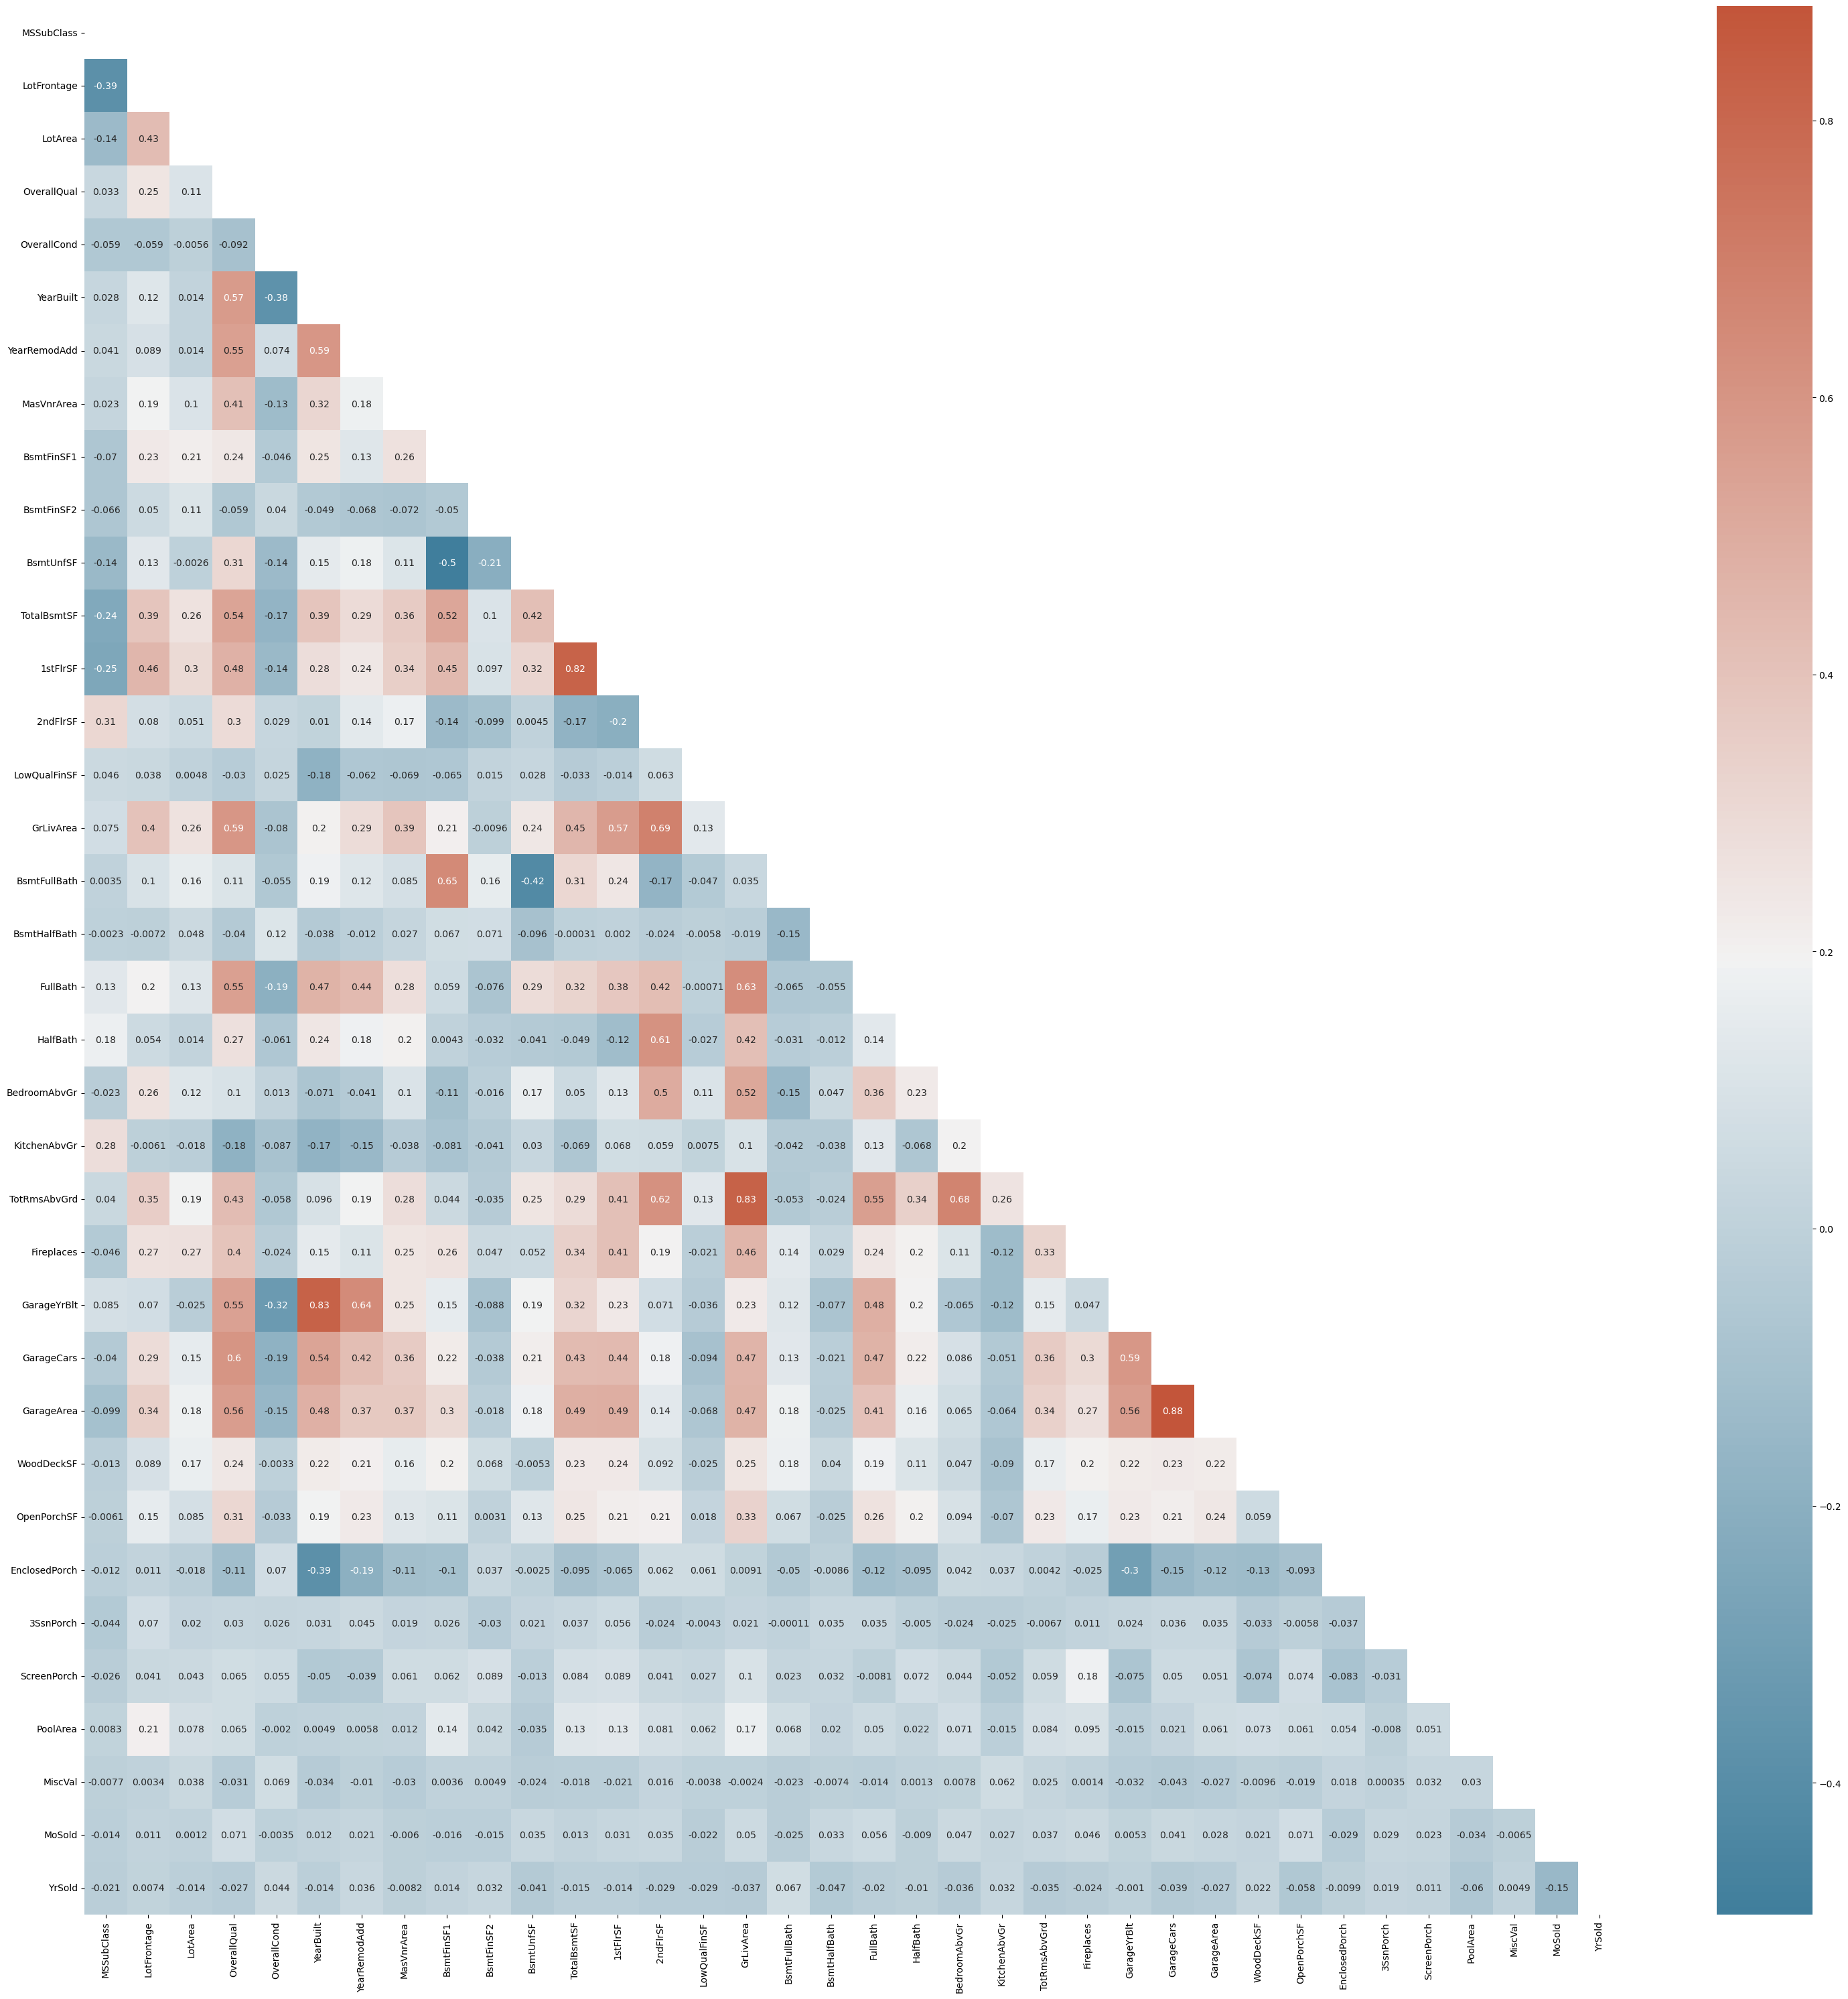

In [4]:
get_corr(df_independent)

Leaving aside the SalePrice for now, there are strong correlations between GarageArea and GarageCars, as well as GarageYrBlt and YearBuilt. TotRmsAbvGr and GrLivArea also show strong correlation, as do 1stFlrSF and TotalBsmtSF. Let's dig into those correlations a little more closely

In [5]:
print(get_vifs(df_independent))


MSSubClass           4.82
LotFrontage         17.30
LotArea              3.43
OverallQual         66.61
OverallCond         49.35
YearBuilt        23377.78
YearRemodAdd     19161.08
MasVnrArea           1.94
BsmtFinSF1            inf
BsmtFinSF2            inf
BsmtUnfSF             inf
TotalBsmtSF           inf
1stFlrSF              inf
2ndFlrSF              inf
LowQualFinSF          inf
GrLivArea             inf
BsmtFullBath         3.60
BsmtHalfBath         1.21
FullBath            24.02
HalfBath             3.38
BedroomAbvGr        33.32
KitchenAbvGr        40.08
TotRmsAbvGrd        83.63
Fireplaces           2.96
GarageYrBlt      24092.62
GarageCars          39.01
GarageArea          34.73
WoodDeckSF           1.93
OpenPorchSF          1.96
EnclosedPorch        1.41
3SsnPorch            1.04
ScreenPorch          1.23
PoolArea             1.19
MiscVal              1.12
MoSold               6.82
dtype: float64


/home/conner/miniconda3/envs/house_price/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


## YearBuilt vs YearRemodAdd
These two columns have a lot of identical values since YearRemodAdd will just contain YearBuilt if the home was never remodeled. Similarly, many garages are built with the house, so those dates are duplicated. Additional binary columns could be added to indicate that an addition/remodel was done, or a garage was built after initial construction.

## Garage

The Garage size (cars and Area) variables are also closely correlated. We will want to choose one or the other when we get to data wrangling

## Area/Room counts
The variables tracking the area of different rooms and the number of rooms are also highly correlated. This is likely because all floors have similar footprints, so the square footage won't differ much, and more room usually means more SqFt. Given the number of different variables that are correlated, keeping them all introduces lots of multicollinearity. We will want to choose only a subset of these variables.

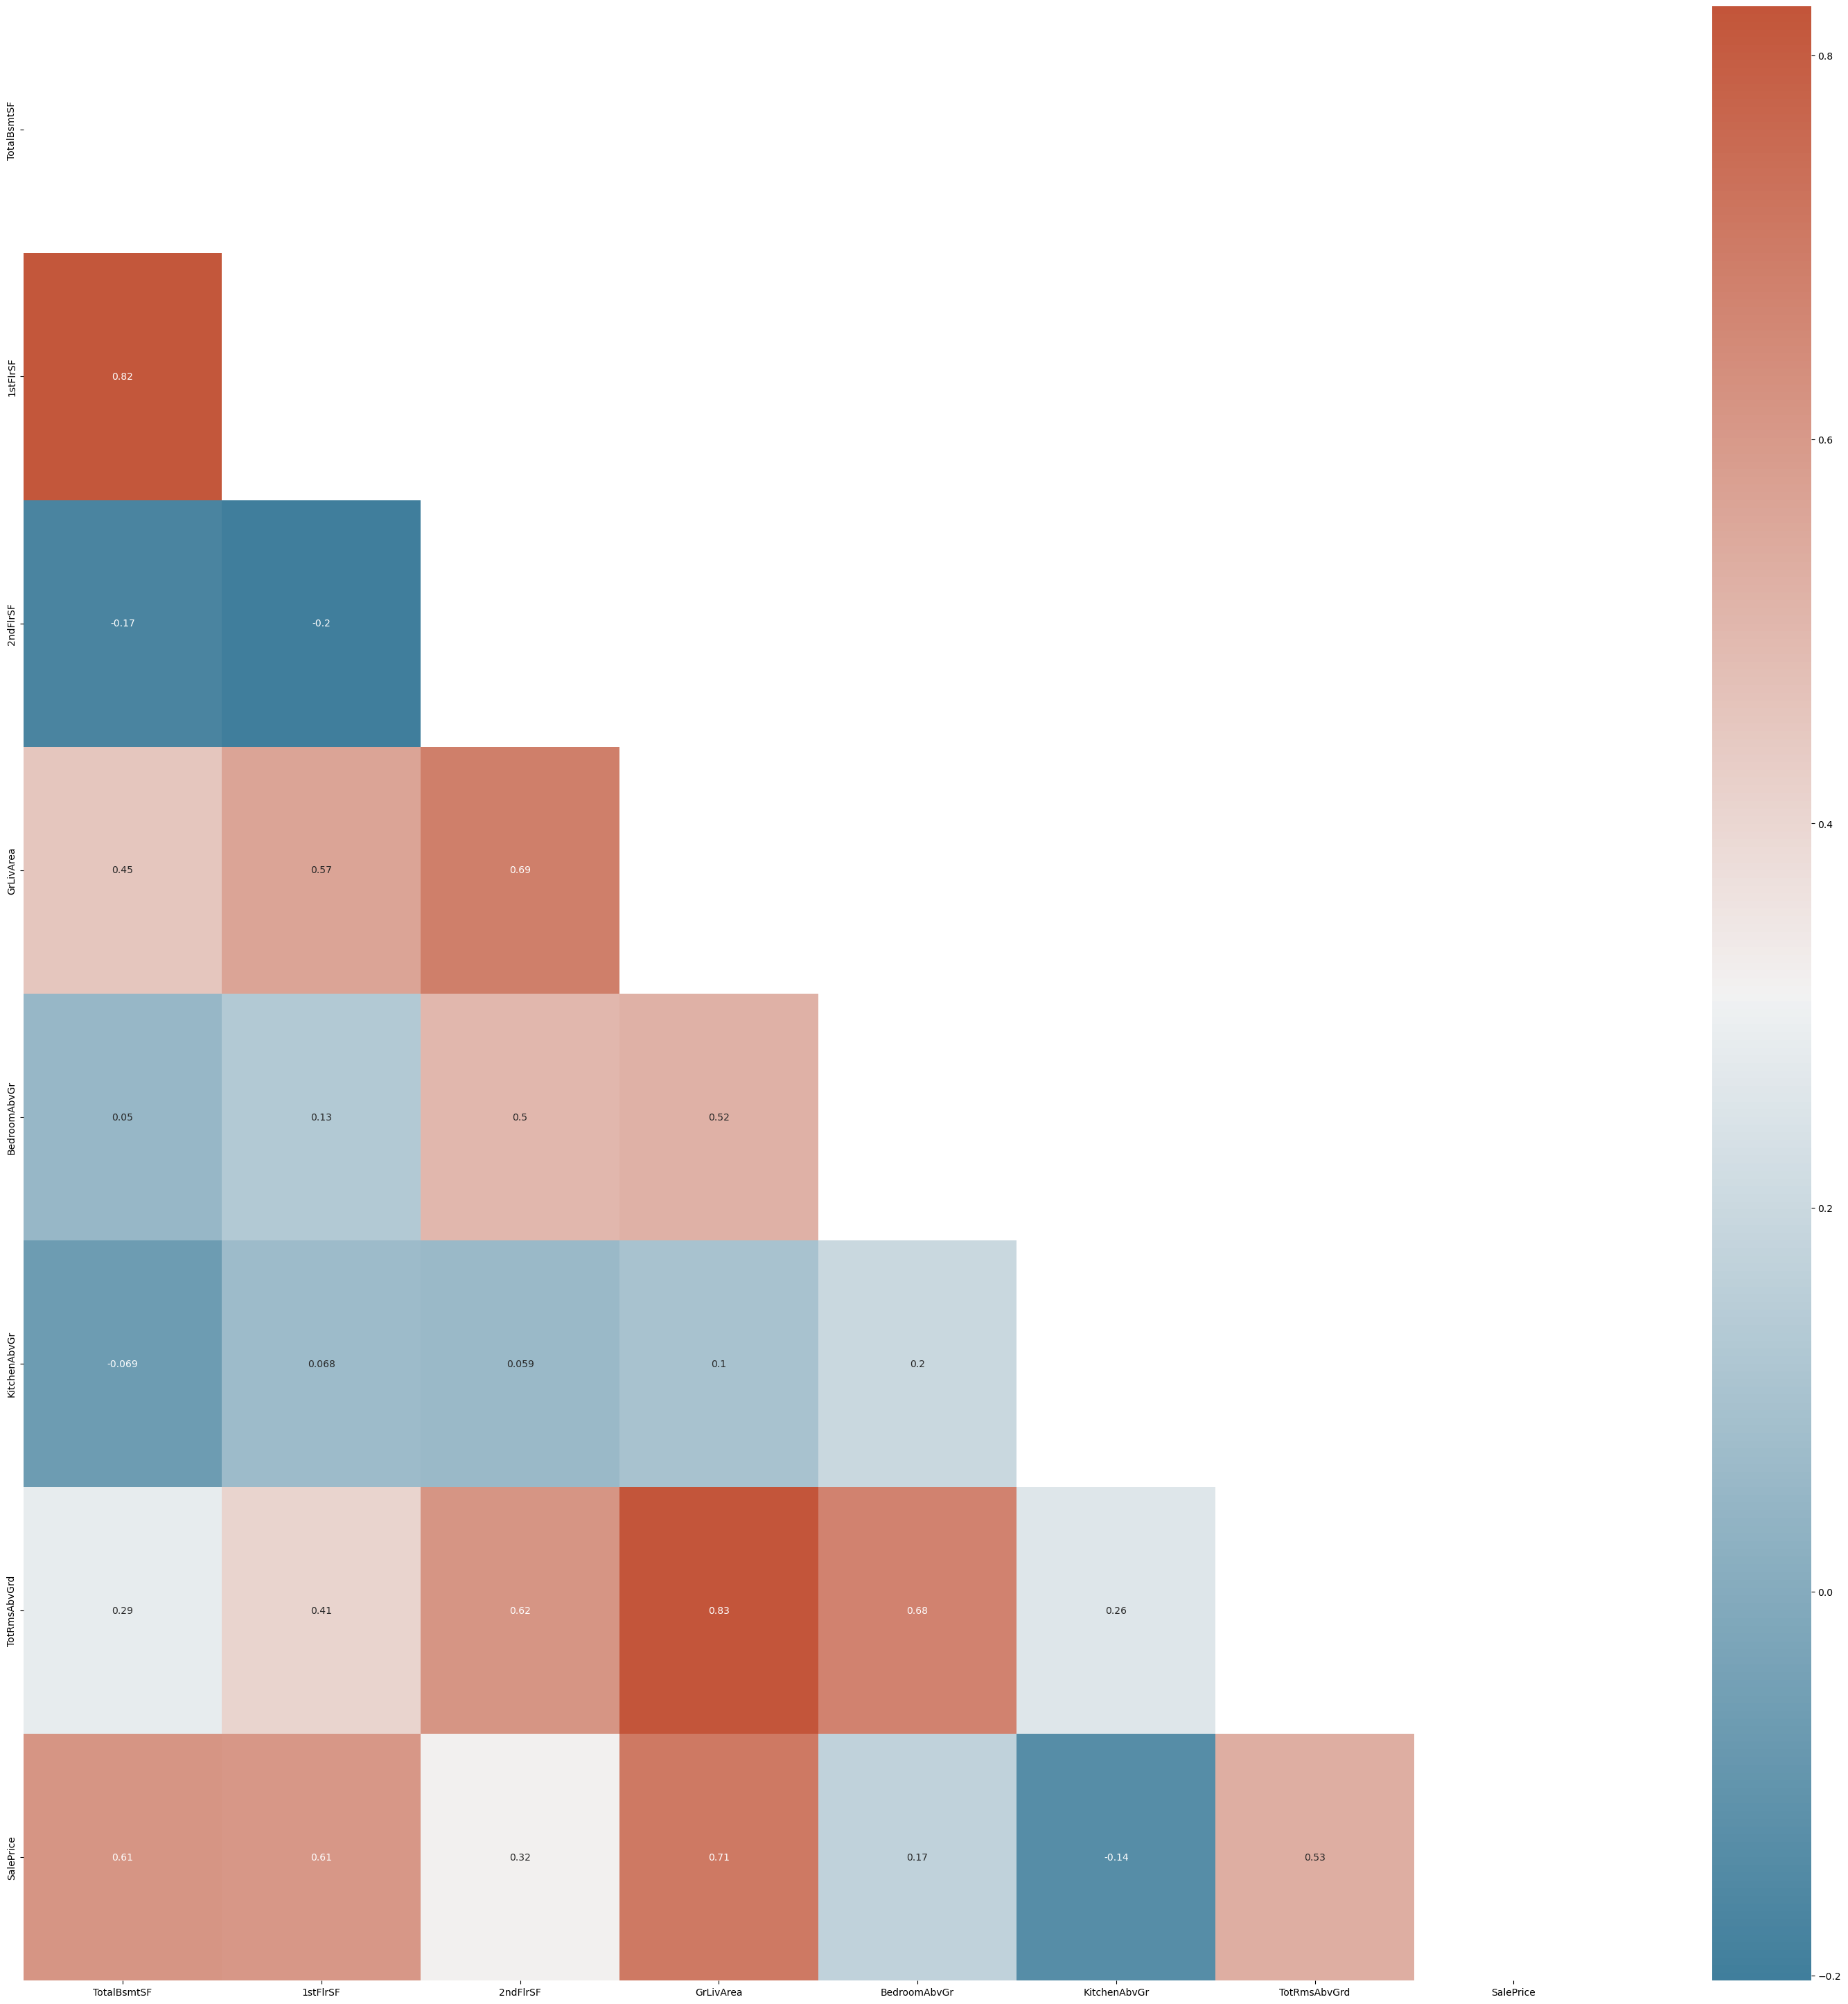

In [20]:
area_and_room_vars = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', "SalePrice"]
get_corr(df[area_and_room_vars])